# Библиотеки

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
from iminuit import Minuit
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import os
import collections
from operator import itemgetter
import glob

from scipy import stats
from scipy.integrate import quad
from scipy import interpolate
import natsort

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['font.size']=15

import Path_to_data

model_atmosphere=Path_to_data.model_atmosphere
model_interaction=Path_to_data.model_interaction
Energy_CR= Path_to_data.Energy_CR
Angle_CR=Path_to_data.Angle_CR
Type_particle_CR=Path_to_data.Type_particle_CR
h = Path_to_data.h

# Директории взятия данных:
direct_mosaic_hits=Path_to_data.direct_mosaic_hits
direct_aberration=Path_to_data.direct_aberration
direct_coord=Path_to_data.direct_coord
direct_bg=Path_to_data.direct_bg

df_coord=pd.read_csv(direct_coord,header=None,sep='\s+',names=['n','x','y','z'])
df_coord['n']=df_coord['n'] #-1
df_coord

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\2000v\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['exp', 'e', 'pi', 'gcd', 'isclose', 'nextafter', 'copysign', 'isnan', 'log10', 'ldexp', 'modf', 'remainder', 'sin', 'nan', 'sinh', 'prod', 'isfinite', 'trunc', 'degrees', 'isinf', 'expm1', 'floor', 'lcm', 'tan', 'inf', 'tanh', 'log2', 'fmod', 'hypot', 'ceil', 'cbrt', 'fabs', 'log', 'gamma', 'cos', 'cosh', 'exp2', 'sqrt', 'log1p', 'frexp', 'radians']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


,n,x,y,z
0,1.0,0.000000e+00,0.000000e+00,528.00000
1,2.0,4.488115e+01,-3.517393e-15,526.08904
2,3.0,2.244057e+01,3.886821e+01,526.08904
3,4.0,-2.244057e+01,3.886821e+01,526.08904
4,5.0,-4.488115e+01,3.055759e-15,526.08904
...,...,...,...,...
104,105.0,1.181802e-14,-2.259575e+02,477.20774
105,106.0,4.408613e+01,-2.256203e+02,475.32715
106,107.0,1.733498e+02,-1.509898e+02,475.32715
107,108.0,1.956849e+02,-1.129787e+02,477.20774


# Учет третьего аспекта аберрации

Text(0, 0.5, '$\\delta$')

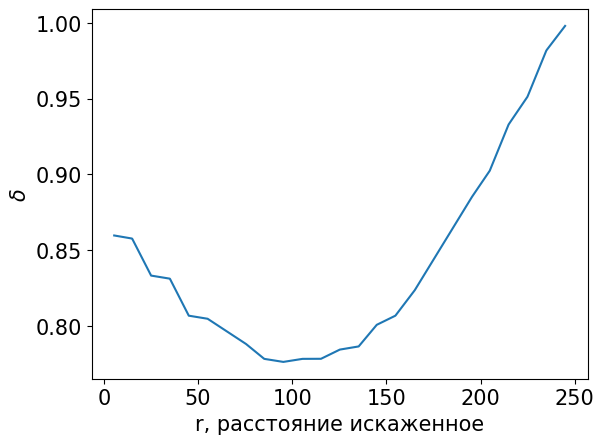

In [2]:
df_data_aberration=pd.read_csv(direct_aberration,sep='\s+',names=['x','d'],header=2)
# Интерполирую функцию дельта из статьи Клеманс для 3 аспекта аберраций.
f_interpolate_aberration=interpolate.interp1d(df_data_aberration['x'],df_data_aberration['d'])

# Демонстрация функции дельта от первоначально смоделированного расстояния.
x_arbitrary=np.arange(df_data_aberration['x'].min(),df_data_aberration['x'].max(),0.2)
y_aberration=f_interpolate_aberration(x_arbitrary)
plt.plot(x_arbitrary,y_aberration)
plt.title
plt.xlabel('r, расстояние искаженное') # расстояние без учета первой аберрации
plt.ylabel(r'$\delta$') # тертья аберрация. Дельта надо умножить на I, чтобы учесть третий аспект аберраций.# Учет третьего аспекта аберрации

# Функции

In [3]:
def extract_data(f_path):
    df_data_mh=pd.read_csv(f_path,header=0,sep='\s+',names=['n','n1','n2','n3','n4','n5','n6','n7'])
    ldf=df_data_mh.groupby('n').agg({'n':['count']})
    ldf=pd.DataFrame({'I':ldf['n']['count']})
    ldf['x']=df_coord['x']
    ldf['y']=df_coord['y']
    return ldf

def ldf_after_aberration(ldf):
    # Учет трех типов оптических аберраций
    x=ldf['x'].to_numpy()
    y=ldf['y'].to_numpy()
    I=ldf['I'].to_numpy()
    
    r=((ldf['x']**2+ldf['y']**2)**(1./2)).to_numpy()
    
    # Учет первого аспекта аберраций. Функция взята из работы Клеманс.
    r1=r/(1-0.0005661*r-6.548e-7*r**2)
    x1=x+(r1-r)*x/r
    y1=y+(r1-r)*y/r
    x1[0],y1[0]=0,0
#     x=x*np.cos(15)
#     y=y*np.cos(15)

    # Учет второго аспекта аберраций. Функция взята из работы Клеманс.
    I2=I/((1+6.548e-7*r**2)/(1-0.0005661*r-6.548e-7*r**2)**3)
    I2[0]=I2[0]*(17/19)**2  # Учет того, что площадь центрального ФЭУ Больше остальных (19 мм, а не 17 мм)
    
    # Учет третьего аспекта аберраций. 
    x_aberration = np.insert(r[1:],0,df_data_aberration['x'].min()) # Вставляю вместо 0 значения минимум интерполяции по х
    delta = f_interpolate_aberration(x_aberration)
    I3=I2/delta
    
    return x1,y1,I3

def xyc_axis_coords(x,y,I):
    # Поиск координат оси ШАЛ, которые будут использованы в качестве первого приближения 
    # для поиска параметров аппроксимирующей функции.
    df_xyI=pd.DataFrame({'x':x,'y':y,'I':I})  
    xc=((df_xyI['x']**2*df_xyI['I']).sum()/df_xyI['I'].sum())**(1./2.)
    yc=((df_xyI['y']**2*df_xyI['I']).sum()/df_xyI['I'].sum())**(1./2)
    if float(max(df_xyI['x'][df_xyI['I']==df_xyI['I'].max()]))<0:
        xc=-xc
    if float(max(df_xyI['y'][df_xyI['I']==df_xyI['I'].max()]))<0:
        yc=-yc
    return xc,yc

def parameters(f_path):
    csv_parameters = f_path.name.split('_')
    m_atm = int(csv_parameters[2][1:])
    type_part = csv_parameters[3]
    E = int(csv_parameters[4][:-3])
    angle=int(csv_parameters[5])
    n_event=int(csv_parameters[6][1:])
    values = {
    'm_atm': m_atm, 'type_part': type_part, 'E': E,
        'angle': angle, 'n_event': n_event ,
    }
    return(values)

def f_name():
    f_name='{}_{}_{}PeV_{}_{}m_{}.txt'.format(model_atmosphere,model_interaction,Energy_CR,Angle_CR,h,Type_particle_CR)
    return f_name
    
def xy_snow(f_path):
    # Читаю первоую строку файла.
    fline=open(f_path).readline().rstrip()
    fline=fline.split()
    n_cl,xcr,ycr,n_event=float(fline[0]),float(fline[2]),float(fline[3]),float(fline[4])
    # Номер клона, координаты х,у -центры оси ливня на снегу, номер события 
    return n_cl,xcr,ycr,n_event

def func(p0,p1,p2,p3,p4,s,x0,y0,x,y):
    # Аппроксимирующая функция
    r=((x-x0)**2+(y-y0)**2)**(1.0/2.0) 
    return p0**2/(1+p1*r+p2*r**2+p3*r**(1.5))**2/(1+p4*r**s)

def error(p0,p1,p2,p3,p4,s,x0,y0):
    #FCN, среднеквадратичное отклонение в данном случае
    global I,x,y
    return (((((I-func(p0,p1,p2,p3,p4,s,x0,y0,x,y)))**2).sum())/len(x))**(1./2)

def minuit_appro(x,y,I,xc,yc):
    # Поиск параметров аппроксимации
    # m=Minuit(error,p0=1000,p1=-0.00089,p2=0.00019,p3=-0.0019,p4=0.27,s=1.3,x0=xc,y0=yc) # Эти параметры в первом приближении
                                                                                        # отлично подходят для энергии Е=10 ПэВ
#     m=Minuit(error,p0=1000,p1=-0.00089,p2=0.00019,p3=-0.0019,p4=0.27,s=1.3,x0=xc,y0=yc) 
    m=Minuit(error,p0=100,p1=-0.00089,p2=0.00019,p3=-0.0019,p4=0.27,s=1.3,x0=xc,y0=yc) 
    s_min,s_max=0.9,1.1
    m.limits['p0']=(0,1000)
    m.limits['p4']=(0.001,1)
    m.limits['s']=(s_min,s_max)
    m.migrad()
    p0,p1,p2,p3,p4,s,x0,y0=m.values
    
    m=Minuit(error,p0=p0,p1=p1,p2=p2,p3=p3,p4=p4,s=s,x0=x0,y0=y0)    
    m.limits['p0']=(0,1000)
    m.limits['p4']=(0.001,1)
    m.limits['s']=(s_min,s_max)
    m.migrad()
    fcn=m.fval #Значение функции в точке минимума
    
    p0,p1,p2,p3,p4,s,x0,y0=m.values
    p0_err,p1_err,p2_err,p3_err,p4_err,s_err,x0_err,y0_err=m.errors
    minuit_val={ 'fcn':fcn,
    'p0':p0,'p1':p1,'p2':p2,'p3':p3,'p4':p4,'s':s,'x0':x0,'y0':y0,
    'p0_err':p0_err,'p1_err':p1_err,'p2_err':p2_err,'p3_err':p3_err,
                'p4_err':p4_err,'s_err':s_err,'x0_err':x0_err,'y0_err':y0_err}
    return (minuit_val)

def f_for_integral(r,p0,p1,p2,p3,p4,s):
    # функция, домноженная на r, необходима для расчета интегралов
    return p0**2*r/(((1+p1*r+p2*r**2+p3*r**(1.5))**2)*(1+p4*r**s))

# Добавляю фон

In [4]:
# Координаты
num_mos= np.array(df_coord['n'])
x_mos= np.array(df_coord['x'])
y_mos= np.array(df_coord['y'])

#ФОН
data_bg=pd.read_csv(Path(direct_bg)/Path('mosaic_hits_'+str(h)+'m_BG001'),header=0,sep='\s+',names=['n','n1','n2','n3','t','n5','n6','n7','n8'])
data_bg['n']=data_bg['n'] #-1
data_bg

num=np.array(data_bg['n'])
t_bg=np.array(data_bg['t'])

def signal_plus_BG(files):
    
    data=pd.read_csv(files,header=0,sep='\s+',names=['n','n1','n2','n3','t','n5','n6','n7'])
    num_ev=np.array(data['n'])
    t_ev=np.array(data['t'])
    
    # #сдвижение фона
    t=t_bg-(min(t_bg)-min(t_ev))
    
    # Дальше код Клеманс по фону
                                                # MANIPULATION FICHIER FOND
    
    num_nbr=np.asarray(sorted(list(collections.Counter(num).items()),key=itemgetter(0))) #число фоновых фотонов в ФЭУ - возр. порядок
    num_t=np.asarray(sorted(np.array([num,t]).T,key=itemgetter(0))) #номер ФЭУ возр. / время прихода
    summ=[int(np.insert(np.cumsum(num_nbr[:,1]),0,0)[i]) for i in range(0,len(num_nbr)+1)]
        
    t_each_pmt=[num_t[:,1][summ[i]:summ[i+1]:1] for i in range(0,len(summ)-1)] #impulse in each PMT

                                                # MANIPULATION FICHIER CASCADE
    num_photons=data.groupby('n').agg({'n':'count'})['n']
    num_photons=pd.DataFrame({'n':num_photons.index,'c':num_photons.to_numpy()})

    num_pmt=pd.DataFrame({'n':np.arange(109)})
    num_nbr_ev_df=num_pmt.merge(num_photons,on='n',how='left').fillna(0)
    num_nbr_ev=num_nbr_ev_df.to_numpy()
    
    num_t_ev=np.asarray(sorted(np.array([num_ev,t_ev]).T,key=itemgetter(0))) #номер ФЭУ возр. / время прихода
    summ_ev=[int(np.insert(np.cumsum(num_nbr_ev[:,1]),0,0)[i]) for i in range(0,len(num_nbr_ev)+1)]
    t_each_pmt_ev=[num_t_ev[:,1][summ_ev[i]:summ_ev[i+1]:1] for i in range(0,len(summ_ev)-1)] #impulse in each PMT
    
    pmt=[int(i) for i in range(109)]
    
    #Средний фон в каждом ФЭУ
    cell=np.arange(min(t),max(t)+12.5,12.5)

    n_sum=[]
    for w in range(0,len(pmt)):
        # w=108
    
        #ONLY BACKGROUND
        n_bg_init=list(np.histogram(t_each_pmt[pmt[w]],bins=cell))[0] #n len=78 #number of t in histogram / PMT
        n_without_mean=n_bg_init[np.where(n_bg_init>=2)] #n: delete BG n < 2
        n_ok=n_without_mean-np.mean(n_without_mean) #n with mean soustracted

        #SIGNAL
        n_bg_init_ev=list(np.histogram(t_each_pmt_ev[w],bins=cell))[0] #n len=78 #number of t in histogram / PMT
        n_ok_ev=n_bg_init_ev[np.where(n_bg_init>=2)] #n: delete BG n < 2

        #BACKGROUND+SIGNAL
        n_bg_ev=n_ok+n_ok_ev #n: signal+ ok background (green bins)
        
        n_end=sum(n_bg_ev)
        if n_end<0: n_end=0
        n_sum.append(n_end)
    return np.asarray(n_sum,dtype='float') 

# Аппроксимация

$$\frac{p_0^2}{(1+p_1  r+p_2  r^2+p_3  r^{1.5})^2  (1+p_4  r^s )}$$

Всего 6 параметров функции, p0=1000,p1=-0.00089,p2=0.00019,p3=-0.0019,p4=0.27, s=1.3. 
Такие значения подходят в качестве первого приближения для событий 10 ПэВ.
При использовании такой аппроксимации не возникает выбросов в интегралах, которые используются для расчета критериев. 
Разделения на группы ядер с помощью обновленной аппроксимации происходит с более высокой точностью в сравнении со старой аппроксимацией (на $2-4$\% лучше).
Уточнение модели ФПР на мозаике телескопа позволило увеличить размерность критерия.

In [5]:
f_list = list(Path(direct_mosaic_hits).glob('**/mos*')) 
idx, jdx = 0, 0
param_out=pd.DataFrame(index=np.arange(6000), 
            columns=['idx','fcn','p0','p1','p2','p3','p4','s','x0','y0','I_max','sum','Rc_snow','Int','err_Int'])

for f_path in f_list[:1000]:

#     df = extract_data(f_path)
    x,y,I=np.array(df_coord['x']),np.array(df_coord['y']),signal_plus_BG(f_path)
    ldf=pd.DataFrame({'x':x,'y':y,'I':I})
    x,y,I=ldf_after_aberration(ldf)    
    xc,yc=xyc_axis_coords(x,y,I)
    
    minuit_values=minuit_appro(x,y,I,xc,yc) 
    
    p0,p1,p2,p3,p4,s,x0,y0=(minuit_values['p0'],minuit_values['p1'],minuit_values['p2'],minuit_values['p3'],
                    minuit_values['p4'],minuit_values['s'],minuit_values['x0'],minuit_values['y0'])
    jdx+=1
    if jdx%200==0: print(jdx)
    if abs(x0)>170 or abs(y0)>170 or I.sum()<1000:
        continue
    else:
        n_cl,xc_snow,yc_snow,n_event=xy_snow(f_path)
        
        param_out['idx'].loc[idx]=jdx-1
        param_out['fcn'].loc[idx]=minuit_values['fcn']
        param_out['p0'].loc[idx]=minuit_values['p0']
        param_out['p1'].loc[idx]=minuit_values['p1']
        param_out['p2'].loc[idx]=minuit_values['p2']
        param_out['p3'].loc[idx]=minuit_values['p3']
        param_out['p4'].loc[idx]=minuit_values['p4']
        param_out['s'].loc[idx]=minuit_values['s']
        param_out['x0'].loc[idx]=minuit_values['x0']
        param_out['y0'].loc[idx]=minuit_values['y0']       
        
        param_out['Rc_snow'].loc[idx]=(xc_snow**2+yc_snow**2)**(1./2)
        param_out['I_max'].loc[idx]=I.max()
        param_out['sum'].loc[idx]=I.sum()
        Integral=quad(f_for_integral,0,200,args=(p0,p1,p2,p3,p4,s))
        param_out['Int'].loc[idx],param_out['err_Int'].loc[idx]=Integral[0],Integral[1]
        idx+=1
print('----DONE----')

200
400
600
800
1000
----DONE----


In [ ]:
import os
direct_out=Path.cwd()/'Sphere-2_result'/'appro_param_with_bg'/model_atmosphere/model_interaction/'{}PeV'.format(Energy_CR)/Angle_CR/'{}m'.format(h)
os.makedirs(direct_out, exist_ok=True)

# param_out.to_csv(direct_out/Path('param_'+f_name()))

# Картинка 3D без фона

----DONE----


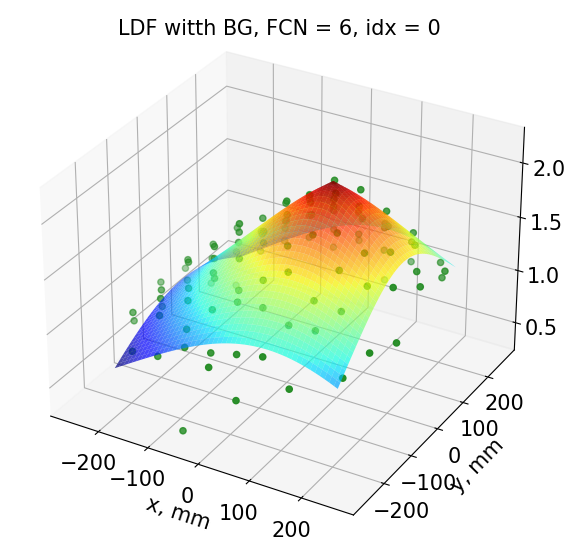

In [7]:
f_list = list(Path(direct_mosaic_hits).glob('**/mos*')) 
idx, jdx = 0, 0
graph_out=Path.cwd()/'graph_sq'
 
X=np.arange(-220,220,1)
Y=np.arange(-220,220,1)
X, Y = np.meshgrid(X, Y)    
    
for f_path in f_list[:1]:
    
    df = extract_data(f_path)
    x,y,I=ldf_after_aberration(df)    
    xc,yc=xyc_axis_coords(x,y,I)
    
    param_in=minuit_appro(x,y,I,xc,yc) 
    
    p0,p1,p2,p3,p4,s,x0,y0=(param_in['p0'],param_in['p1'],param_in['p2'],param_in['p3'],
                    param_in['p4'],param_in['s'],param_in['x0'],param_in['y0'])
    
    jdx+=1
    if jdx%200==0: print(jdx)
        
    Q=func(p0,p1,p2,p3,p4,s,x0,y0,x,y)
    sigm2=((I-Q)**2).sum()
    diff=(I-Q)/I

    n_cl,x_telescope,y_telescope,n_event=xy_snow(f_path)
    r=(x**2+y**2)**(1./2)
    #print(param_in['fcn'][idx])
        
        
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot( projection='3d')
    surf = ax.plot_surface(X, Y, np.log10(func(p0,p1,p2,p3,p4,s,x0,y0,X,Y)),alpha=0.7,cmap='jet',label='fit')
    ax.scatter(x,y,np.log10(I),color='forestgreen',label='LDF')

    plt.title('LDF witth BG, FCN = '+ str(round(param_in['fcn']))+', idx = '+ str(int(idx)),fontsize = 15,y=1.02)
    plt.xlabel(' x, mm',fontsize = 15)
    plt.ylabel(' y, mm',fontsize = 15)

    idx+=1
#     plt.savefig(Path(graph_out)/('graphs_sq_'+str(int(idx))+'.png'),bbox_inches='tight')
print('----DONE----')

# Картинка 3D с фоном

Text(0.5, 0.5, ' y, mm')

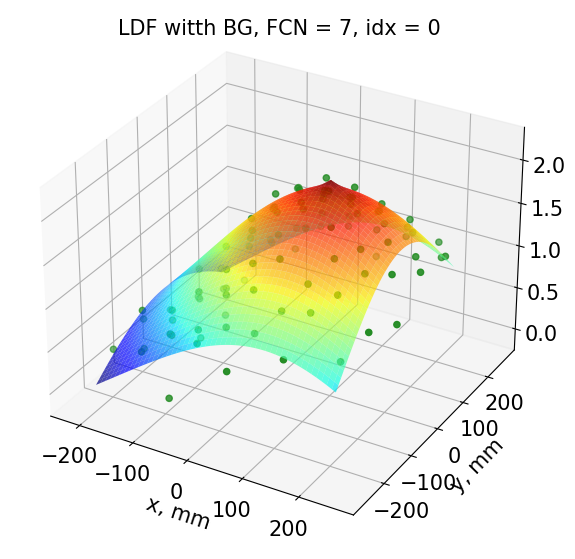

In [8]:
idx, jdx = 0, 0
x,y,I=np.array(df_coord['x']),np.array(df_coord['y']),signal_plus_BG(f_path)
ldf=pd.DataFrame({'x':x,'y':y,'I':I})
x,y,I=ldf_after_aberration(ldf) 
xc,yc=xyc_axis_coords(x,y,I)   

param_in=minuit_appro(x,y,I,xc,yc) 
    
p0,p1,p2,p3,p4,s,x0,y0=(param_in['p0'],param_in['p1'],param_in['p2'],param_in['p3'],
                    param_in['p4'],param_in['s'],param_in['x0'],param_in['y0'])
    

        
Q=func(p0,p1,p2,p3,p4,s,x0,y0,x,y)
sigm2=((I-Q)**2).sum()
# diff=(I-Q)/I

ldf_map=pd.DataFrame({'x':x,'y':y,'I':I})
ldf_map=ldf_map[ldf_map['I']>1]
# print(ldf_map)

# n_cl,x_telescope,y_telescope,n_event=xycr(f_path)
r=(x**2+y**2)**(1./2)
#print(param_in['fcn'][idx])
        
# print(np.log10(ldf_map['I']))        
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot( projection='3d')
surf = ax.plot_surface(X, Y, np.log10(func(p0,p1,p2,p3,p4,s,x0,y0,X,Y)),alpha=0.7,cmap='jet',label='fit')
ax.scatter(ldf_map['x'],ldf_map['y'],np.log10(ldf_map['I']),color='forestgreen',label='LDF')

plt.title('LDF witth BG, FCN = '+ str(round(param_in['fcn']))+', idx = '+ str(int(idx)),fontsize = 15,y=1.02)
plt.xlabel(' x, mm',fontsize = 15)
plt.ylabel(' y, mm',fontsize = 15)

# idx+=1
# plt.savefig(Path(graph_out)/('graphs_sq_'+str(int(idx))+'.png'),bbox_inches='tight')

# Исследование основных параметров аппроксимации
Если все распределения имеют один выроденный максимум и распределены нормально, то все аппроксимировалось хорошо.
Если нет, то имеет смысл поэкспериментировать с первоначальными параметрами функции аппроксимации, особенно с параметром p_0, так как он сильно связан с энергией первичной частицы. 

(array([69., 49., 53., 65., 84., 70., 40.,  7.,  0.,  1.]),
 array([ 277306.44200358,  414227.50068635,  551148.55936912,
         688069.61805189,  824990.67673466,  961911.73541743,
        1098832.7941002 , 1235753.85278297, 1372674.91146574,
        1509595.97014851, 1646517.02883128]),
 <BarContainer object of 10 artists>)

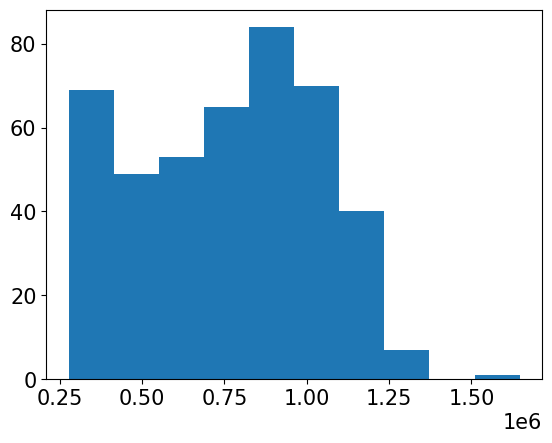

In [54]:
plt.hist(param_out['Int'])

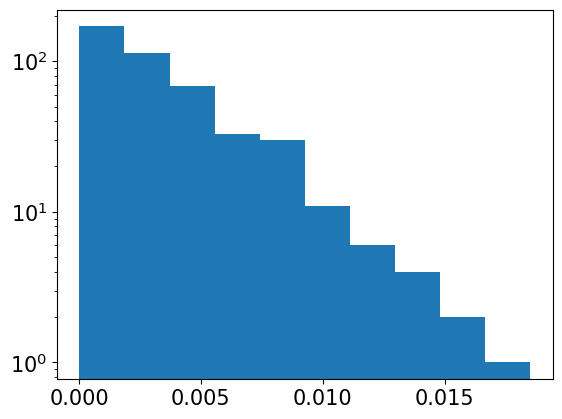

In [55]:
plt.hist(param_out['err_Int'])
plt.yscale('log')

(array([176., 127.,  49.,  31.,  19.,  14.,  11.,   8.,   2.,   1.]),
 array([ 3.30337911, 11.86230606, 20.42123301, 28.98015996, 37.53908691,
        46.09801385, 54.6569408 , 63.21586775, 71.7747947 , 80.33372165,
        88.8926486 ]),
 <BarContainer object of 10 artists>)

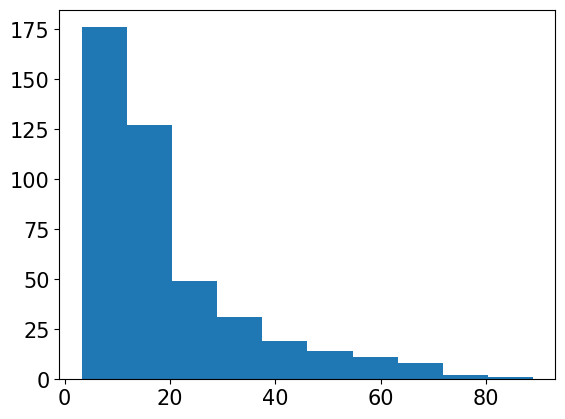

In [56]:
plt.hist(param_out['p0'])

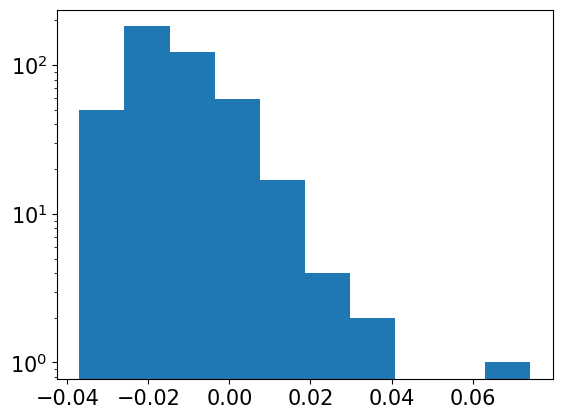

In [57]:
plt.hist(param_out['p1'])
plt.yscale('log')

(array([ 33., 106., 108.,  75.,  55.,  36.,  13.,   6.,   4.,   2.]),
 array([ 4.04655618,  5.71304719,  7.37953819,  9.0460292 , 10.71252021,
        12.37901121, 14.04550222, 15.71199323, 17.37848423, 19.04497524,
        20.71146624]),
 <BarContainer object of 10 artists>)

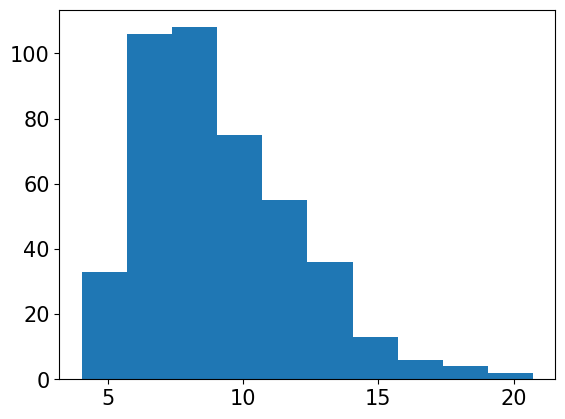

In [58]:
plt.hist(param_out['fcn'])